In [1]:
import pandas as pd
import numpy as np

import seaborn as sns

import re

from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

import gensim
from gensim import corpora, models, similarities
from gensim.models import CoherenceModel, HdpModel
from gensim.models.nmf import Nmf

from collections import OrderedDict

In [2]:
data_file = "./dreaddit/dreaddit-train-allTexts.csv"
train_df = pd.read_csv(data_file)
train_df.head()

,subreddit,text,sentiment
0,ptsd,"He said he had not felt that way before, sugge...",-0.002742
1,assistance,"Hey there r/assistance, Not sure if this is th...",0.292857
2,ptsd,My mom then hit me with the newspaper and it s...,0.011894
3,relationships,"until i met my new boyfriend, he is amazing, h...",0.141671
4,survivorsofabuse,October is Domestic Violence Awareness Month a...,-0.204167


## EDA

In [3]:
# How many human annotated topics are in the data?
stress_topics = list(set(train_df['subreddit'].tolist()))
print("Number of stress topics in the data: {}".format(len(stress_topics)))

Number of stress topics in the data: 10


In [4]:
# the shape of the data: how many tweets are in the data set?
print("Shape of the data: {}".format(train_df.shape))

Shape of the data: (2838, 3)


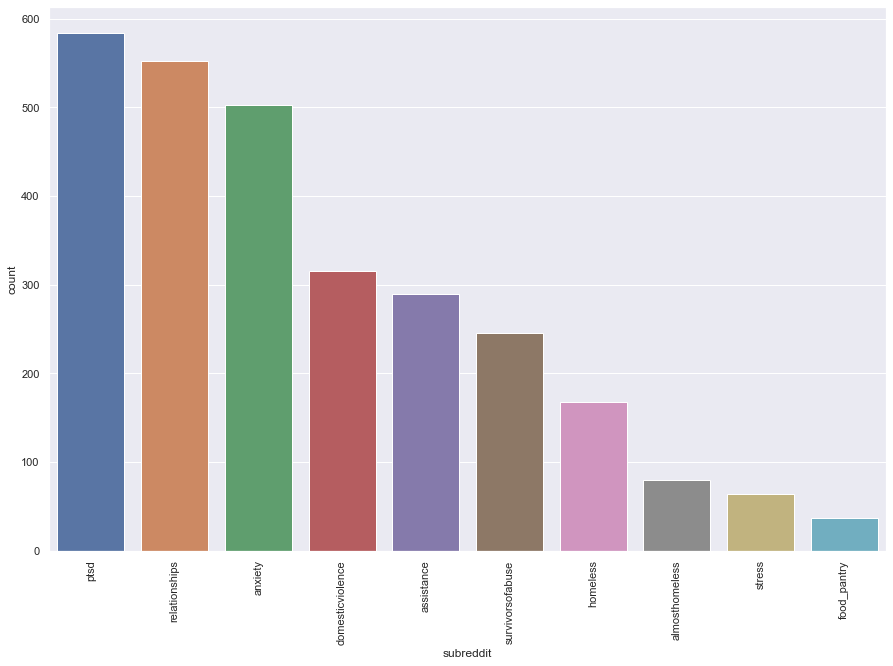

In [5]:
# the distributions of stress topics in the data via a barplot
sns.set(rc={'figure.figsize':(15,10)})
by_topic = sns.countplot(x='subreddit', data=train_df, order = train_df['subreddit'].value_counts().index)

for item in by_topic.get_xticklabels():
    item.set_rotation(90)

Because some subreddits are more or less popular, the amount of data in each domain varies. We include ten total subreddits from five domains in our dataset. 

In [6]:
def getDomainsfromTopics(topic):
    if topic in ['domesticviolence', 'survivorsofabuse']:
        return 'abuse'
    elif topic in ['anxiety', 'stress']:
        return 'anxiety'
    elif topic in ['almosthomeless', 'assistance', 'food_pantry', 'homeless']:
        return 'financial'
    elif topic == 'ptsd':
        return 'PTSD'
    elif topic == 'relationships':
        return 'social'

train_df['domains'] = train_df.apply(lambda x: getDomainsfromTopics(x.subreddit), axis=1)
train_df.head()

,subreddit,text,sentiment,domains
0,ptsd,"He said he had not felt that way before, sugge...",-0.002742,PTSD
1,assistance,"Hey there r/assistance, Not sure if this is th...",0.292857,financial
2,ptsd,My mom then hit me with the newspaper and it s...,0.011894,PTSD
3,relationships,"until i met my new boyfriend, he is amazing, h...",0.141671,social
4,survivorsofabuse,October is Domestic Violence Awareness Month a...,-0.204167,abuse


In [7]:
# How many stress domains are in the data now?
stress_domains = list(set(train_df['domains'].tolist()))
print("Number of stress domains in the data: {}".format(len(stress_domains)))

Number of stress domains in the data: 5


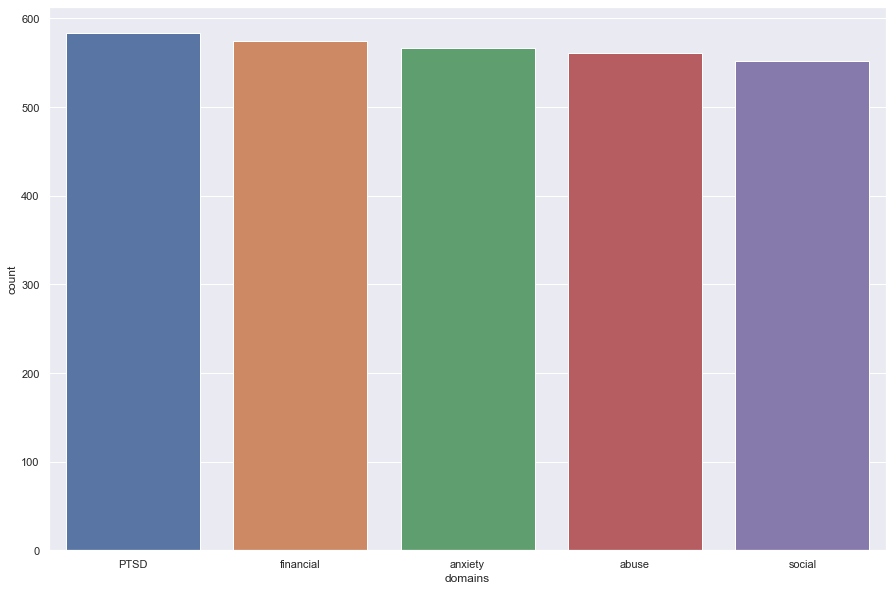

In [8]:
# the distributions of stress domains in the data via a barplot
sns.set(rc={'figure.figsize':(15,10)})
by_domain = sns.countplot(x='domains', data=train_df, order = train_df['domains'].value_counts().index)

for item in by_topic.get_xticklabels():
    item.set_rotation(90)

In [9]:
def getSentiLabelFromScores(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'
    
train_df['senti_label'] = train_df.apply(lambda x: getSentiLabelFromScores(x.sentiment), axis=1)
train_df.head()

,subreddit,text,sentiment,domains,senti_label
0,ptsd,"He said he had not felt that way before, sugge...",-0.002742,PTSD,Negative
1,assistance,"Hey there r/assistance, Not sure if this is th...",0.292857,financial,Positive
2,ptsd,My mom then hit me with the newspaper and it s...,0.011894,PTSD,Positive
3,relationships,"until i met my new boyfriend, he is amazing, h...",0.141671,social,Positive
4,survivorsofabuse,October is Domestic Violence Awareness Month a...,-0.204167,abuse,Negative


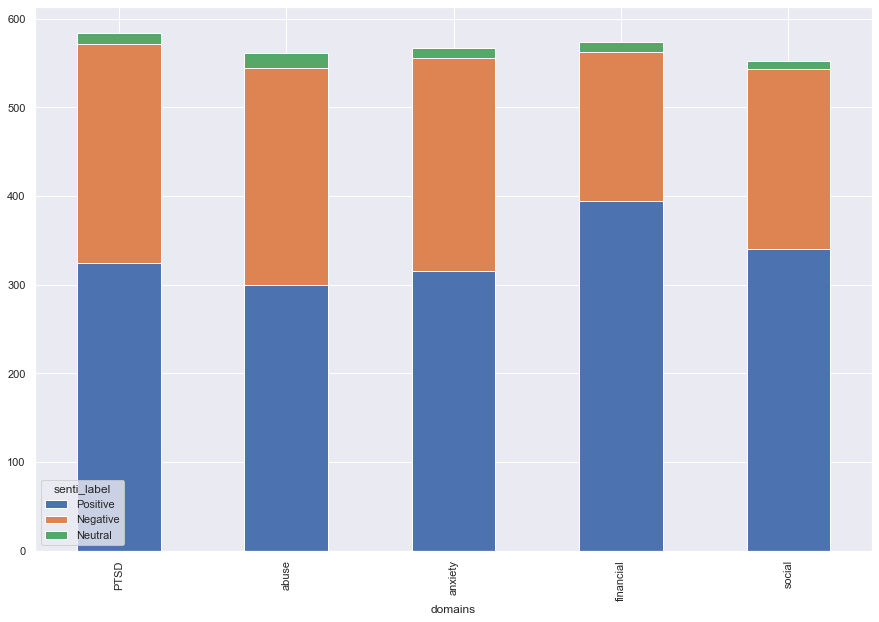

In [10]:
# Take a look at the distributions of human annotated/tagged sentiment by topic via a barplot
senti_labels = list(set(train_df['senti_label'].tolist()))
df_sentiment = train_df.groupby(['domains', 'senti_label'])['domains'].count().unstack('senti_label')
domains_mixture = df_sentiment[senti_labels].plot(kind='bar', stacked=True, legend = True)

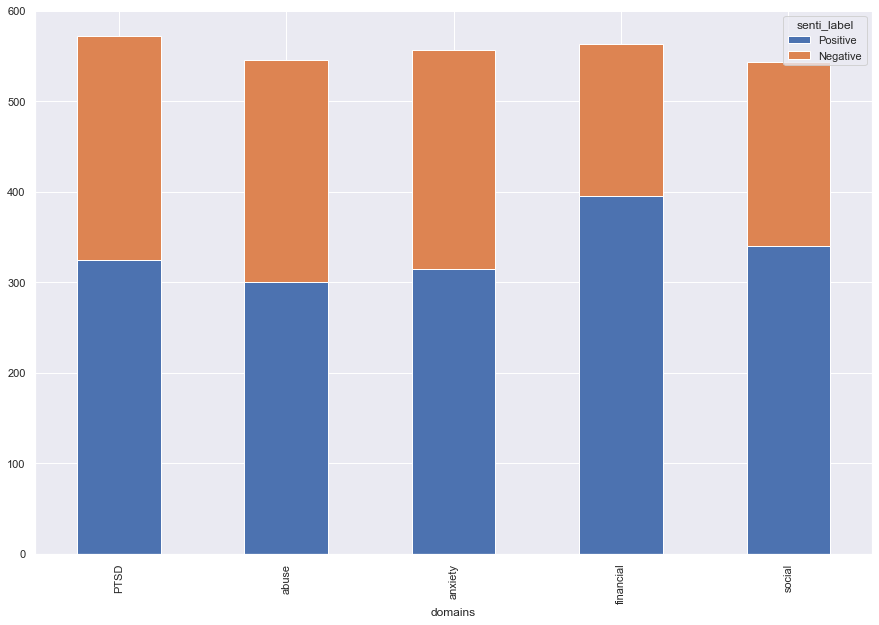

In [11]:
# drop Neutral rows since there are too few records
train_df = train_df.loc[train_df.senti_label != 'Neutral']
# Take a look at the distributions of human annotated/tagged sentiment by topic via a barplot
senti_labels = list(set(train_df['senti_label'].tolist()))
df_sentiment = train_df.groupby(['domains', 'senti_label'])['domains'].count().unstack('senti_label')
domains_mixture = df_sentiment[senti_labels].plot(kind='bar', stacked=True, legend = True)

In [12]:
train_df.head()

,subreddit,text,sentiment,domains,senti_label
0,ptsd,"He said he had not felt that way before, sugge...",-0.002742,PTSD,Negative
1,assistance,"Hey there r/assistance, Not sure if this is th...",0.292857,financial,Positive
2,ptsd,My mom then hit me with the newspaper and it s...,0.011894,PTSD,Positive
3,relationships,"until i met my new boyfriend, he is amazing, h...",0.141671,social,Positive
4,survivorsofabuse,October is Domestic Violence Awareness Month a...,-0.204167,abuse,Negative


## Model

In [13]:
# Prepare the corpus for analysis
def preprocess_text(text, stem=False):
    """Preprocess one sentence: tokenizes, lowercases, applies the Porter stemmer,
     removes punctuation tokens and stopwords.
     Returns a list of strings."""
    toks = word_tokenize(text)
    # clean
    stops = stopwords.words('english')
    selfdefined_stops = ["n't", "the", "it", "get", "got", "gets", 
                         "my", "also", "one", "could", "would", "can", 
                         "as", "said", "go", "goes", "going", "went", 
                         "also", "is", "since", "these", "so", "really", 
                         "much", "what", "the", "still", "every", "any", 
                         "it", "make", "but" , "my"]
    stopwords_list = stops + selfdefined_stops
    # stem
    if stem:
        stemmer = PorterStemmer()
        toks = [stemmer.stem(tok) for tok in toks]
    # remove punctuation
    toks_nopunc = [tok.lower() for tok in toks if tok not in string.punctuation]
    # remove stopwords
    toks_nostop = [tok for tok in toks_nopunc if tok not in stopwords_list]
    toks_tidy = [tok for tok in toks_nostop if re.match(r'[a-zA-Z]+', tok) and len(tok) >= 2]
    return toks_tidy

In [14]:
train_df['text'] = train_df.apply(lambda x: preprocess_text(x.text), axis = 1)
train_df.head()

,subreddit,text,sentiment,domains,senti_label
0,ptsd,"[felt, way, suggeted, rest, trigger, ahead, yo...",-0.002742,PTSD,Negative
1,assistance,"[hey, r/assistance, sure, right, place, post, ...",0.292857,financial,Positive
2,ptsd,"[mom, hit, newspaper, shocked, knows, like, pl...",0.011894,PTSD,Positive
3,relationships,"[met, new, boyfriend, amazing, kind, sweet, go...",0.141671,social,Positive
4,survivorsofabuse,"[october, domestic, violence, awareness, month...",-0.204167,abuse,Negative


In [15]:
texts = train_df['text']
dictionary = corpora.Dictionary(texts)
print(dictionary.token2id)

{'age': 0, 'ahead': 1, 'ailments': 2, 'b.s.': 3, 'conspiracy': 4, 'decide': 5, 'doom': 6, 'ended': 7, 'even': 8, 'feelings': 9, 'felt': 10, 'getting': 11, 'gloom': 12, 'happen': 13, 'health': 14, 'heart': 15, 'hole': 16, 'hopes': 17, 'hours': 18, 'hypocondriac': 19, 'indicative': 20, 'laugh': 21, 'like': 22, 'look': 23, 'ludicrous': 24, 'maybe': 25, 'new': 26, 'physical': 27, 'prone': 28, 'psychic': 29, 'rabbit': 30, 'reading': 31, 'rest': 32, 'road': 33, 'sense': 34, 'something': 35, 'stupid': 36, 'sucked': 37, 'suggeted': 38, 'test': 39, 'top': 40, 'trigger': 41, 'various': 42, 'way': 43, 'worried': 44, 'youi': 45, 'along': 46, 'amazon': 47, 'appreciate': 48, 'around': 49, 'chance': 50, 'country': 51, 'current': 52, 'currently': 53, 'drawing': 54, 'efforts': 55, 'entered': 56, 'everyone': 57, 'gcs': 58, 'greatly': 59, 'help': 60, 'helps': 61, 'hey': 62, 'improve': 63, 'intern': 64, 'know': 65, 'labs': 66, 'looking': 67, 'many': 68, 'marketing': 69, 'national': 70, 'outreach': 71, 'pa

In [16]:
# A major question in using LDA for topic modeling is what is is the proper set of
# hyperparmeters to generate the optimal set of topics for the coprus of documents
# under examination. Gensim includes methods for computing the Perplexity and Topic 
# Coherence of a corpus. One appraoch is to sample an LDA model for a range of 
# for perplexity and topic coherence and select the appropriate number of topics
# from a point of minimum perplexity and maximium topic coherence.

texts = train_df['text']
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# However, recent studies have shown that predictive likelihood (or equivalently, perplexity) and human judgment are often not correlated, 
# and even sometimes slightly anti-correlated.
# So only using coherence score to evaluate models in our project
# perplexity_lda = []
coherence_lda = []
topic_count_lda = []

for num_topics in range(2, 16, 1):
    
    print("Computing the lda model using {} topics".format(num_topics))
    
    topic_lda = models.LdaModel(corpus,
                                id2word = dictionary,
                                num_topics = num_topics,
                                iterations = 1000,
                                alpha = 'auto')
    corpus_lda = topic_lda[corpus] # Use the bow corpus
    
    topic_count_lda.append(num_topics)
    
#     # a measure of how good the model is. the lower, the better.
#     perplexity_lda.append(topic_lda.log_perplexity(corpus))

    # Compute Coherence Score
    cm = CoherenceModel(model=topic_lda, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    coherence_lda.append(cm.get_coherence())

Computing the lda model using 2 topics
Computing the lda model using 3 topics
Computing the lda model using 4 topics
Computing the lda model using 5 topics
Computing the lda model using 6 topics
Computing the lda model using 7 topics
Computing the lda model using 8 topics
Computing the lda model using 9 topics
Computing the lda model using 10 topics
Computing the lda model using 11 topics
Computing the lda model using 12 topics
Computing the lda model using 13 topics
Computing the lda model using 14 topics
Computing the lda model using 15 topics


In [17]:
# Pull the resulting data into a pandas dataframe
topics_lda = pd.DataFrame({'coherence': coherence_lda},
                         index = topic_count_lda)

topics_lda

,coherence
2,-2.073531
3,-2.137204
4,-2.332375
5,-2.342988
6,-2.358334
7,-2.328593
8,-2.476045
9,-2.560226
10,-2.371839
11,-2.895499


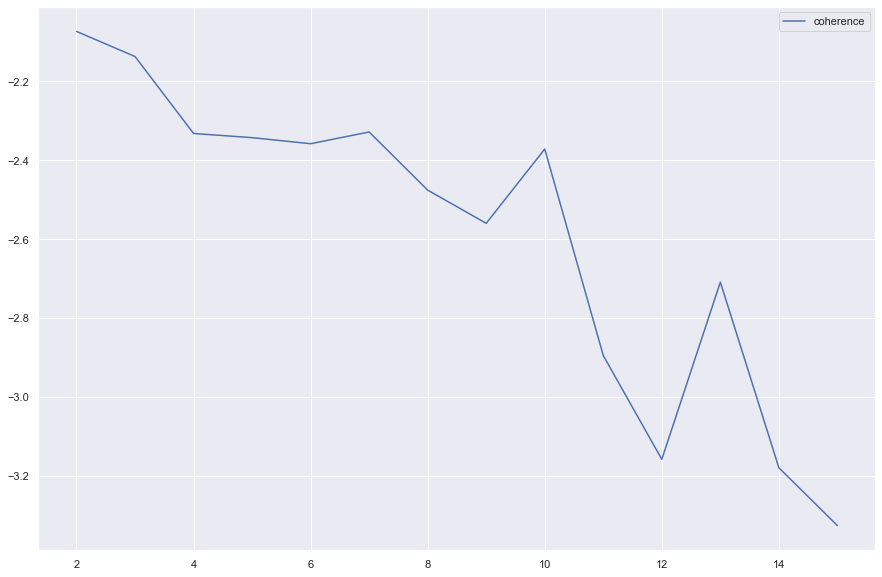

In [18]:
lines = topics_lda.plot.line()
# the higher the better, but there is no statistically significant difference between 2, 3 and 4 topics
# -> try all these possiblities and compare the results.

In [19]:
# Gensim LDA stores all the text for processing into a corpus object
texts = train_df['text']
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
# the higest coherence
total_topics = 3

# lda model
lda_model = models.LdaModel(corpus, id2word = dictionary, num_topics = total_topics, iterations = 1000, alpha='auto')
# Show first n=10 important words in the topics:
lda_model.show_topics(total_topics, 10)

[(0,
  '0.010*"like" + 0.009*"time" + 0.008*"know" + 0.008*"feel" + 0.005*"want" + 0.005*"help" + 0.005*"even" + 0.004*"life" + 0.004*"things" + 0.004*"back"'),
 (1,
  '0.011*"like" + 0.010*"know" + 0.007*"want" + 0.007*"even" + 0.007*"time" + 0.006*"help" + 0.006*"feel" + 0.006*"think" + 0.004*"years" + 0.004*"people"'),
 (2,
  '0.010*"like" + 0.005*"even" + 0.005*"back" + 0.005*"know" + 0.005*"feel" + 0.005*"day" + 0.004*"anxiety" + 0.004*"people" + 0.004*"work" + 0.004*"help"')]

In [20]:
# Load the topic - term data into an python dictionary
data_lda_model = {i: OrderedDict(lda_model.show_topic(i,10)) for i in range(total_topics)}
data_lda_model

{0: OrderedDict([('like', 0.010432537),
              ('time', 0.008706713),
              ('know', 0.008453416),
              ('feel', 0.0084411455),
              ('want', 0.005117905),
              ('help', 0.004745273),
              ('even', 0.0045008096),
              ('life', 0.0043950994),
              ('things', 0.004211995),
              ('back', 0.0041452507)]),
 1: OrderedDict([('like', 0.01126685),
              ('know', 0.009851025),
              ('want', 0.0074812085),
              ('even', 0.0072267824),
              ('time', 0.006935497),
              ('help', 0.0061393366),
              ('feel', 0.005918196),
              ('think', 0.005602814),
              ('years', 0.0042927163),
              ('people', 0.0042725215)]),
 2: OrderedDict([('like', 0.009872618),
              ('even', 0.0054232785),
              ('back', 0.0050782515),
              ('know', 0.004998875),
              ('feel', 0.004892948),
              ('day', 0.004739859),
          

In [21]:
# infer the distribution of topics according to the lda model
topics = []
probs = []
max_to_show = 10

for k, i in enumerate(range(len(texts))):
    try:
        bow = dictionary.doc2bow(texts[i])
        doc_topics = lda_model.get_document_topics(bow, minimum_probability = 0.01)
        # topic with the highest probability
        topics_sorted = sorted(doc_topics, key = lambda x: x[0], reverse = True)
        topics.append(topics_sorted[0][0])
        probs.append("{}".format(topics_sorted[0][1]))

        # Dump out the topic and probability assignments for the first 20 texts
        if k < max_to_show:
            print("Text {}: {}".format(k, topics_sorted))
    except KeyError:
        pass

train_df['LDAtopic'] = pd.Series(topics)
train_df['LDAprob'] = pd.Series(probs)

Text 0: [(1, 0.995095)]
Text 1: [(1, 0.9956351)]
Text 2: [(0, 0.99734586)]
Text 3: [(1, 0.34550923), (0, 0.6536543)]
Text 4: [(2, 0.672453), (1, 0.32420793)]
Text 5: [(2, 0.9936568)]
Text 6: [(0, 0.9961877)]
Text 7: [(1, 0.6355264), (0, 0.36246702)]
Text 8: [(0, 0.9956861)]
Text 9: [(2, 0.8674686), (1, 0.1279569)]


In [22]:
# Resort the dataframe according to the human annotated topic and lda topic
train_df.sort_values(['domains', 'LDAtopic'], ascending=[True, True], inplace=True)
train_df.head(10)

,subreddit,text,sentiment,domains,senti_label,LDAtopic,LDAprob
2,ptsd,"[mom, hit, newspaper, shocked, knows, like, pl...",0.011894,PTSD,Positive,0.0,0.9973458647727966
30,ptsd,"[blown, away, doctor, willingness, help, feel,...",-0.062500,PTSD,Negative,0.0,0.9948790669441223
45,ptsd,"[run, url, seeks, tell, honest, stories, peopl...",0.250000,PTSD,Positive,0.0,0.9966481328010559
52,ptsd,"[things, think, contributed, less, traumatic, ...",0.152778,PTSD,Positive,0.0,0.9974651336669922
56,ptsd,"[pregnancy, traumatic, birth, first, child, sy...",0.126407,PTSD,Positive,0.0,0.9971102476119995
74,ptsd,"[remember, getting, drunk, ranting, fuck, budd...",-0.081771,PTSD,Negative,0.0,0.9950374364852905
79,ptsd,"[help, stop, ruminating, work, pretty, toxic, ...",-0.212500,PTSD,Negative,0.0,0.9957954287528992
101,ptsd,"[trauma, survivors, often, need, awareness, ne...",0.162338,PTSD,Positive,0.0,0.9970623254776001
103,ptsd,"[ok, firstly, say, formally, diagnosed, point,...",0.206250,PTSD,Positive,0.0,0.9954509735107422
105,ptsd,"[thanks, alma, mater, like, know, suggestions,...",0.168182,PTSD,Positive,0.0,0.9943525195121765


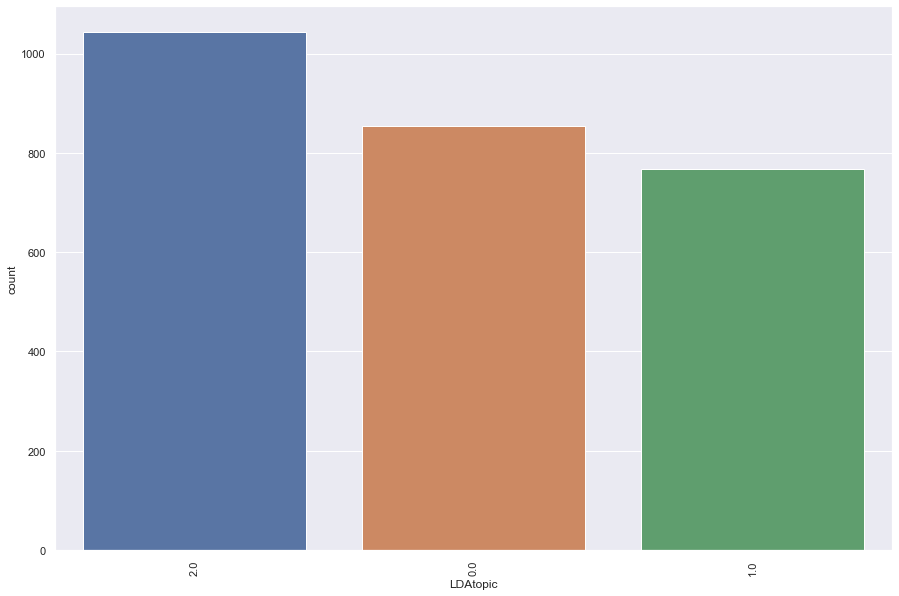

In [23]:
# the distributions of LDA assigned topics in the data via a barplot
sns.set(rc={'figure.figsize':(15,10)})
by_topic = sns.countplot(x='LDAtopic', data=train_df, order = train_df['LDAtopic'].value_counts().index)

for item in by_topic.get_xticklabels():
    item.set_rotation(90)

In [24]:
# Resort the dataframe according to the the lda assigned topic and the assocoiated probability
train_df.sort_values(['LDAtopic', 'LDAprob'], ascending=[True, False], inplace=True)
train_df.head(10)

,subreddit,text,sentiment,domains,senti_label,LDAtopic,LDAprob
317,assistance,"[fucked, shit, happen, detail, looking, sympat...",-2.650000e-01,financial,Negative,0.0,0.9983683228492737
952,relationships,"[fast, forward, tired, rather, leave, even, th...",1.200000e-01,social,Positive,0.0,0.9983175992965698
930,ptsd,"[certainty, scared, fuck, want, bad, work, bet...",1.390000e-17,PTSD,Positive,0.0,0.9982829689979553
1960,relationships,"[dated, ex-girlfriend, years, madly, love, rel...",-7.430556e-02,social,Negative,0.0,0.9980141520500183
1540,relationships,"[say, tl, dr, friend, struggling, alcoholism, ...",1.000000e-01,social,Positive,0.0,0.9980124235153198
1749,relationships,"[okay, say, rude, joke, back, though, take, po...",-7.142857e-03,social,Negative,0.0,0.9979674816131592
1763,ptsd,"[woke, took, nurses, sort, shot, calm, woke, l...",-6.507937e-02,PTSD,Negative,0.0,0.9978637099266052
347,anxiety,"[life, spiralled, area, sure, survive, longer,...",-6.459524e-02,anxiety,Negative,0.0,0.9978607296943665
332,ptsd,"[va, see, people, need, good, living, want, li...",2.194444e-01,PTSD,Positive,0.0,0.9976732730865479
2325,anxiety,"[tells, everyone, comes, must, given, birth, c...",1.980952e-01,anxiety,Positive,0.0,0.9976522326469421


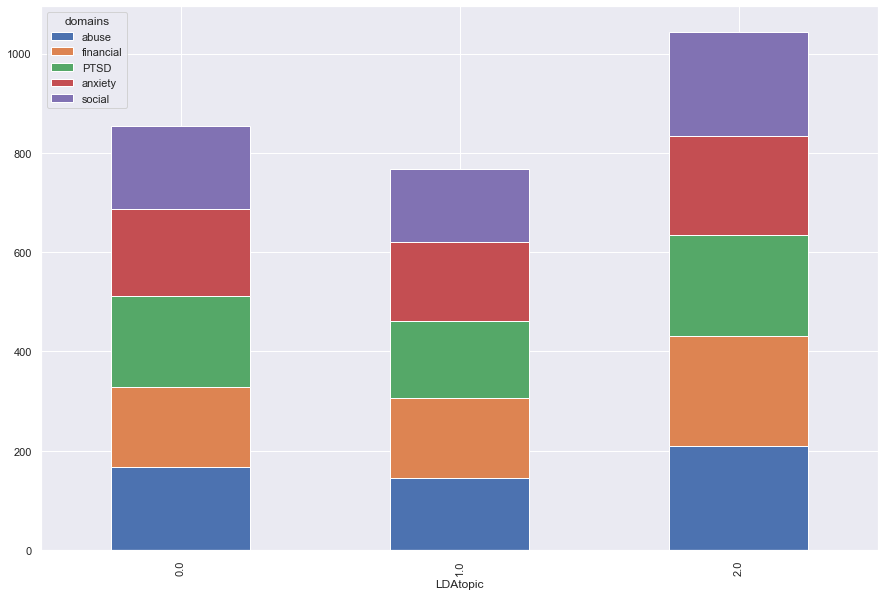

In [25]:
# the topic distrubtions related to the original human annotated/tagged topics
df = train_df.groupby(['LDAtopic', 'domains'])['LDAtopic'].count().unstack('domains')
topic_mixture = df[stress_domains].plot(kind='bar', stacked=True, legend = True)

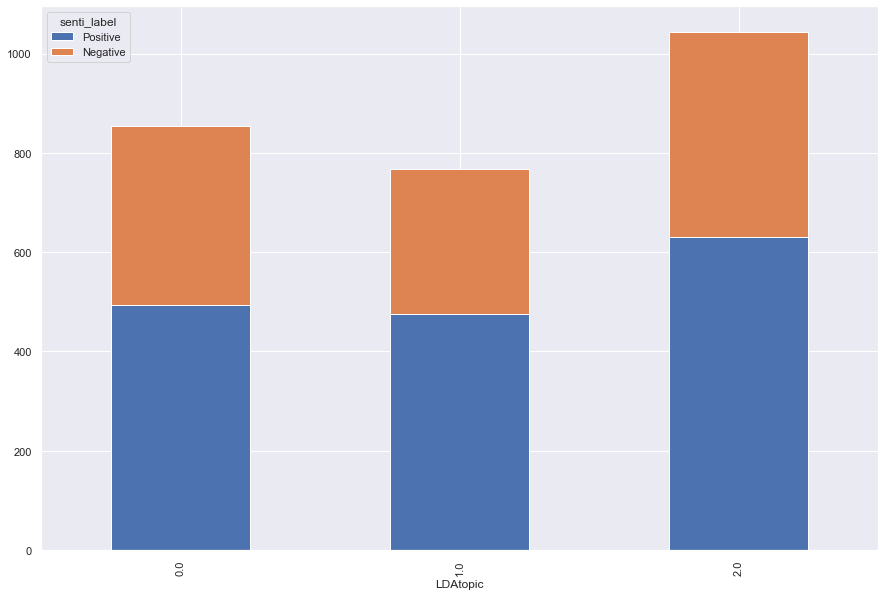

In [26]:
#  the topic distrubtions related to the original human annotated/tagged sentiment
human_sentiment = list(set(train_df['senti_label'].tolist()))
df2 = train_df.groupby(['LDAtopic', 'senti_label'])['LDAtopic'].count().unstack('senti_label')
topic_mixture = df2[human_sentiment].plot(kind='bar', stacked=True, legend = True)

In [27]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis

In [28]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.013938 -0.045112       1        1  43.962009
2     -0.037199  0.033233       2        1  29.141157
1      0.051137  0.011879       3        1  26.896837, topic_info=        Term        Freq       Total Category  logprob  loglift
192     want  509.000000  509.000000  Default  30.0000  30.0000
8       even  546.000000  546.000000  Default  29.0000  29.0000
65      know  777.000000  777.000000  Default  28.0000  28.0000
127    think  365.000000  365.000000  Default  27.0000  27.0000
663  support   99.000000   99.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
299     life   79.892769  378.733765   Topic3  -5.8129  -0.2430
357   anyone   68.267860  266.027161   Topic3  -5.9702  -0.0470
355  anxiety   71.912659  350.471680   Topic3  -5.9182  -0.2707
260     back   72.804276  401.002136   Topic3  -5.9058  -0.3930
129     told   65.234528  255.330765   Topic3  -6.0156  -0.0514

[292 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
7427      1  0.068003      abusing
7427      2  0.884038      abusing
7427      3  0.068003      abusing
638       3  0.927059  accountable
8972      3  0.936067  acknowledge
...     ...       ...          ...
135       2  0.348839         year
135       3  0.331613         year
230       1  0.446242        years
230       2  0.247027        years
230       3  0.305464        years

[479 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

When there are 3 topics in this corpus, these topic clusters achieve the furthest distances, 
indicating the distinguishing differences between these topics.